# Data Preprocessing

In [112]:
# Load Dataset

from pandas import read_csv

housing_dataset_filename = "housing.csv"
housing_dataset = read_csv(housing_dataset_filename)

housing_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-117.61,34.13,21.0,8416.0,1386.0,4308.0,1341.0,4.4611,INLAND,164600.0
1,-117.37,33.98,52.0,201.0,44.0,130.0,24.0,2.0250,INLAND,125000.0
2,-118.34,33.89,36.0,2274.0,411.0,1232.0,423.0,5.3730,<1H OCEAN,244500.0
3,-118.92,35.13,29.0,1297.0,262.0,909.0,253.0,1.9236,INLAND,106300.0
4,-121.80,37.23,18.0,3179.0,526.0,1663.0,507.0,5.9225,<1H OCEAN,265800.0
...,...,...,...,...,...,...,...,...,...,...
16507,-119.53,36.55,34.0,2065.0,343.0,1041.0,313.0,3.2917,INLAND,111500.0
16508,-122.40,37.73,50.0,1947.0,411.0,1170.0,384.0,3.4769,NEAR BAY,238700.0
16509,-118.41,33.92,29.0,1436.0,401.0,674.0,343.0,3.6389,<1H OCEAN,275000.0
16510,-117.08,32.62,36.0,1674.0,309.0,818.0,307.0,3.4773,NEAR OCEAN,150400.0


## Missing Values

In [113]:
housing_dataset.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [95]:
from pandas import concat

housing_dataset_missing_bedrooms = housing_dataset[housing_dataset['total_bedrooms'].isna()]
housing_dataset_contain_bedrooms = housing_dataset[housing_dataset['total_bedrooms'].notna()]

d_missing = housing_dataset_missing_bedrooms.drop('ocean_proximity', axis=1)
d_contain = housing_dataset_contain_bedrooms.drop('ocean_proximity', axis=1)

d_mean_missing = d_missing.mean().rename('mean_missing')
d_mean_contain = d_contain.mean().rename('mean_contain')
d_mean = concat([d_mean_missing, d_mean_contain], axis=1)

d_std_missing = d_missing.std().rename('std_missing')
d_std_contain = d_contain.std().rename('std_contain')
d_std = concat([d_std_missing, d_std_contain], axis=1)

d_mean_diff = (d_mean_missing - d_mean_contain) / d_std_contain

display(concat([d_mean, d_std, d_mean_diff.rename('missing_std_from_mean')], axis=1))

,mean_missing,mean_contain,std_missing,std_contain,missing_std_from_mean
longitude,-119.454821,-119.560505,2.034241,2.003196,0.052757
latitude,35.517917,35.618924,2.124548,2.134194,-0.047328
housing_median_age,29.166667,28.664219,12.495109,12.616550,0.039824
total_rooms,2607.767857,2639.549009,1835.148476,2201.921714,-0.014433
total_bedrooms,NaN,538.522026,NaN,425.256071,NaN
population,1471.452381,1424.693771,1078.197713,1147.745539,0.040740
households,513.857143,499.759178,402.369573,385.199342,0.036599
median_income,3.849036,3.873539,1.959443,1.911920,-0.012816
median_house_value,203417.898810,207291.292523,112751.550797,115719.523632,-0.033472


## Ocean Proximity Distributions

<1H OCEAN     7301
INLAND        5203
NEAR OCEAN    2159
NEAR BAY      1845
ISLAND           4
Name: ocean_proximity, dtype: int64

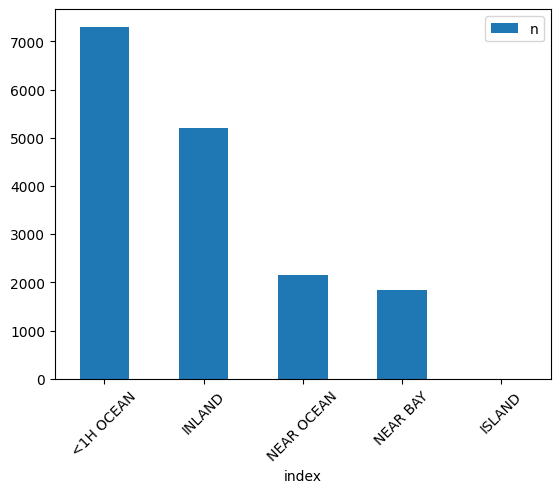

In [114]:
ocean_proximity_type_counts = housing_dataset['ocean_proximity'].value_counts()
ocean_proximity_types = housing_dataset['ocean_proximity'].astype('category').values

ocean_proximity_type_counts \
    .reset_index(name="n") \
    .plot.bar(x='index', y='n', rot=45)

display(ocean_proximity_type_counts)

<AxesSubplot: xlabel='index'>

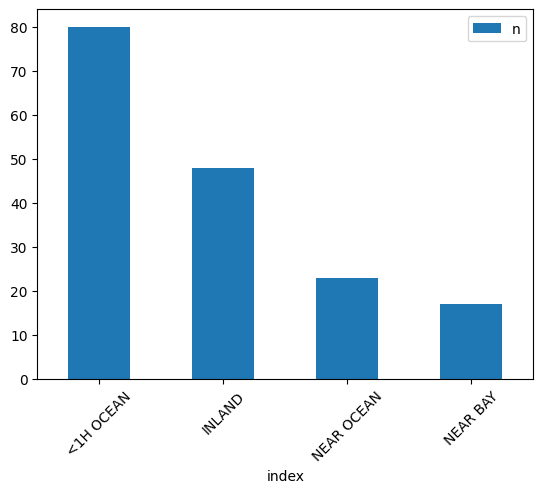

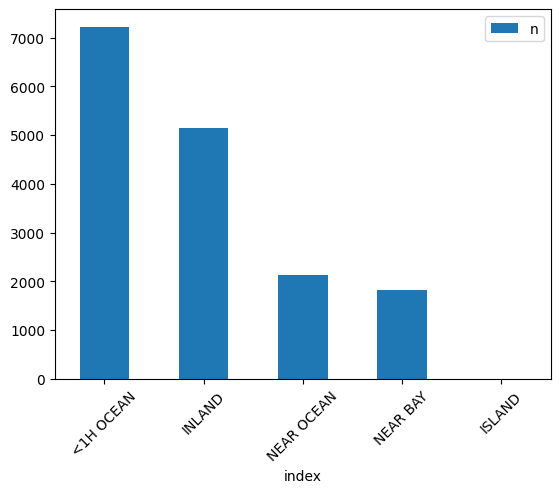

In [111]:
ocean_proximity_missing_type_counts = housing_dataset_missing_bedrooms['ocean_proximity'].value_counts()
ocean_proximity_contain_type_counts = housing_dataset_contain_bedrooms['ocean_proximity'].value_counts()

ocean_proximity_missing_type_counts \
    .reset_index(name="n") \
    .plot.bar(x='index', y='n', rot=45)

ocean_proximity_contain_type_counts \
    .reset_index(name="n") \
    .plot.bar(x='index', y='n', rot=45)

In [113]:
# Drop Total Bedrooms = NaN Rows

housing_dataset = housing_dataset[housing_dataset['total_bedrooms'].notna()]

# Normalisation

In [115]:
from pandas import DataFrame
from pickle import dump, load
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

training = True

i_transformer = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), [
            'longitude',
            'latitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
        ]),
        ('one_hot', OneHotEncoder(), ['ocean_proximity']),
    ],
    remainder='drop'
)

o_transformer = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), ['median_house_value'])
    ],
    remainder='drop'
)


if training:
    i_transformer.fit(housing_dataset)
    o_transformer.fit(housing_dataset)
    dump(i_transformer, open('pickle/i_transformer.pickle', 'wb'))
    dump(o_transformer, open('pickle/o_transformer.pickle', 'wb'))
else:
    i_transformer = load(open('pickle/i_transformer.pickle', 'rb'))
    o_transformer = load(open('pickle/o_transformer.pickle', 'rb'))

i_housing_dataset = DataFrame(
    i_transformer.transform(housing_dataset),
    columns=i_transformer.get_feature_names_out(),
)

o_housing_dataset = DataFrame(
    o_transformer.transform(housing_dataset),
    columns=o_transformer.get_feature_names_out(),
)

display(i_housing_dataset)
display(o_housing_dataset)


,std__longitude,std__latitude,std__housing_median_age,std__total_rooms,std__total_bedrooms,std__population,std__households,std__median_income,one_hot__ocean_proximity_<1H OCEAN,one_hot__ocean_proximity_INLAND,one_hot__ocean_proximity_ISLAND,one_hot__ocean_proximity_NEAR BAY,one_hot__ocean_proximity_NEAR OCEAN
0,0.973051,-0.697236,-0.607970,2.627733,1.992926,2.513359,2.182650,0.307385,0.0,1.0,0.0,0.0,0.0
1,1.092846,-0.767527,1.849488,-1.109097,-1.162916,-1.129177,-1.234968,-0.966531,0.0,1.0,0.0,0.0,0.0
2,0.608674,-0.809702,0.581123,-0.166133,-0.299880,-0.168412,-0.199562,0.784247,1.0,0.0,0.0,0.0,0.0
3,0.319169,-0.228631,0.026213,-0.610550,-0.650268,-0.450016,-0.640713,-1.019556,0.0,1.0,0.0,0.0,0.0
4,-1.118373,0.755441,-0.845788,0.245532,-0.029447,0.207349,0.018418,1.071599,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16339,0.014690,0.436789,0.422577,-0.261203,-0.459789,-0.334933,-0.485013,-0.304132,0.0,1.0,0.0,0.0,0.0
16340,-1.417861,0.989744,1.690942,-0.314879,-0.299880,-0.222466,-0.300768,-0.207285,0.0,0.0,0.0,1.0,0.0
16341,0.573734,-0.795643,0.026213,-0.547322,-0.323396,-0.654897,-0.407163,-0.122570,1.0,0.0,0.0,0.0,0.0
16342,1.237599,-1.404831,0.581123,-0.439061,-0.539743,-0.529353,-0.500583,-0.207076,0.0,0.0,0.0,0.0,1.0


,std__median_house_value
0,-0.368695
1,-0.711008
2,0.321983
3,-0.872656
4,0.506106
...,...
16339,-0.827705
16340,0.271846
16341,0.585633
16342,-0.491443
